# Locality sensitive hashing using MinHash

The idea behind locality sensitive hashing is to take the document fingerprints and chop them up into pieces, each piece being some number of `minhash`es. Since a single `minhash` (single entry in the fingerprint) has a probability equal to the Jaccard similarity of producing a collision, each chopped up portion of the fingerprint should as well. This chopped up portion is the `locality` in locality sensitive hashing, the `hashing` is just a hash function (any hash function) which produces a `bin ID` from the fingerprint `locality` being hashed. Each bin holds the entire fingerprint (with optional meta information) of the document and that of other documents that hash to the same `bin`.

Let's say our fingerprint has 100 `minhash`es in it and we chop the fingerprints into 10 pieces. Each piece of each fingerprint therefore contains 10 `minhash`es, we hash those again (not using `minhash` this time) to get a `bin ID` and store the whole fingerprint in every bin each of the pieces happens to land in.

When we want to know which documents are similar to a query document, we look in all the bins the query document lands in, any document in any of the bins is a potential duplicate. Comparing the full fingerprint of all documents in the bin or computing the actual Jaccard similarity between the shingle sets yields the final similarity of documents. Crucially _since not all documents will land in the same bins we've reduced the number of comparisons needed to find similar or near duplicate documents_.

The number of pieces to chop each fingerprint into and the size of each piece are parameters that need to be set. These should be set such that $num\_pieces \times size\_of\_piece == num\_minhashes$ - this makes sense since having computed all the $N$ `minhash`es we want to use all of them in the locality sensitive hashing part. There is however a further issue that needs to be considered when setting the parameters; the relation between the number and size of the pieces and the probability of LSH "finding" a pair of similar documents.

LSH is a probabilistic model which means that it won't always do the "right thing". Using LSH one needs to consider the similarity of a pair of documents (in this case the Jaccard similarity) and the probability that LSH will find that pair to be similar (a true positive, i.e. a correctly discovered duplicate pair). The pair of documents LSH finds to be similar should be thought of as _candidate_ duplicates. The higher the probability, or guarantee, that LSH will find a pair of documents to be similar the more false positives the model will also produce, that is candidate duplicates that are not in fact duplicates.

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

ix = pd.IndexSlice

## How setting LSH parameters affects finding similar documents

Create a pandas dataframe with different configurations for b and r values. The different sizes are as follows: (2, 50), (50, 2), (10, 10), (5, 20), (20, 5).

For every b and r compute the probability values using the equation discussed in class i.e, $p = 1 - (1 - t^b)^r$. Vary the threshold value from 0 to 1 with around 200 intervals.

Create a pandas pivot table with the columns hashes, bands, row.

Initialize a plot with figsize of (10, 7) and title "Probability of LSH of finding a candidate pair"

Set ylabel to be "p" and xlabel to be "Jaccard Similarity". Now display the plot with the different values. 

b :  2 	 r :  50


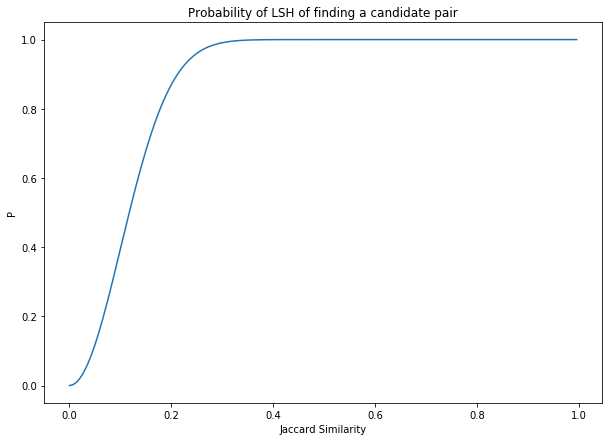

b :  50 	 r :  2


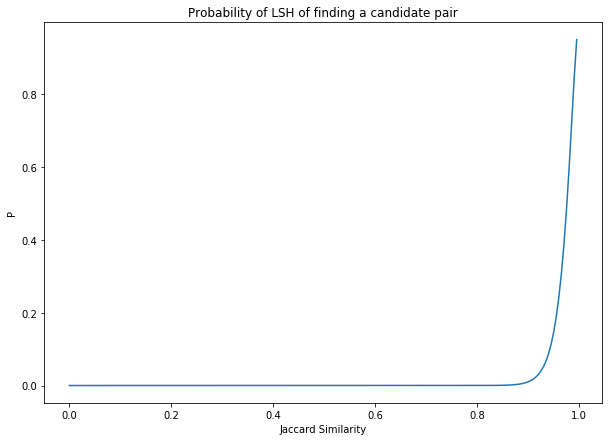

b :  10 	 r :  10


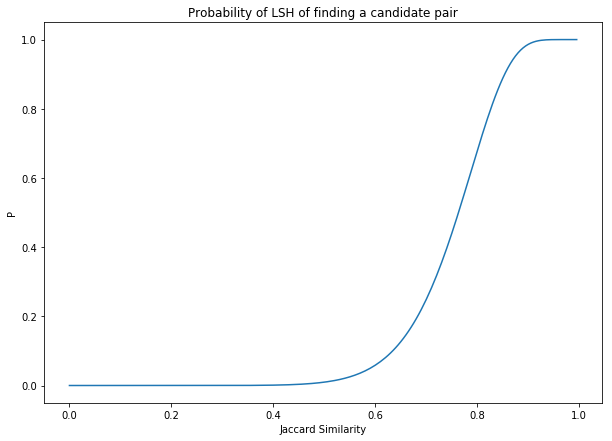

b :  5 	 r :  20


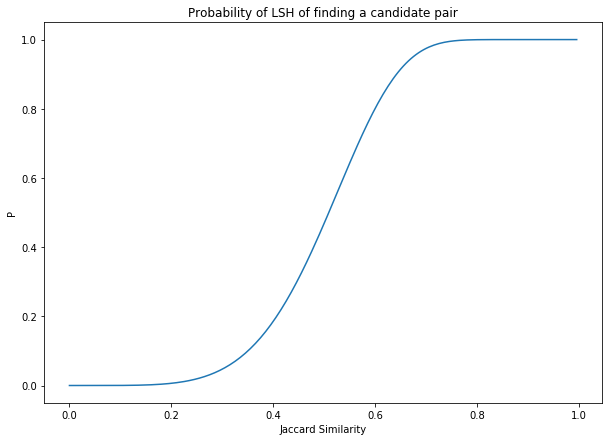

b :  20 	 r :  5


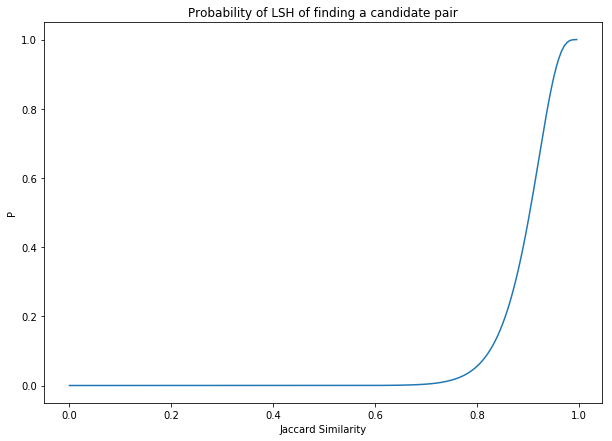

In [30]:
comb = [[2,50],[50,2],[10,10],[5,20],[20,5]] 


data = pd.DataFrame(comb,columns = ['b','r'])
T = np.arange(0,1,0.005)    
X = []
for z in data.itertuples():
    b = z[1]
    r = z[2]
    l = []
    for t in T:
        l.append(1-pow((1-pow(t,b)),r))
    X.append(l)
    

for i in range(len(comb)):
    print('b : ',comb[i][0],'\t r : ',comb[i][1])
    plt.figure(figsize=(10,7))
    plt.title('Probability of LSH of finding a candidate pair')
    plt.xlabel('Jaccard Similarity')
    plt.ylabel('P')
    plt.plot(T,X[i])

    plt.show()



## Computing LSH

Now import the MinHash function from your last assignment to get the MinHashSim matrix. You may re-insert the entire function too here.

In [31]:
import re
import os
import random
import time
import binascii
import sys
import string
import sys


fstart = time.time()
numHashes = 100

numDocs = 1000
numElems = int(numDocs * (numDocs - 1) / 2)


jacard = [0 for j in range(numElems)]
minHashSim = [0 for i in range(numElems)]

dataFile = 'docs_'+str(numDocs) + '.train'
plagFile = 'docs_'+str(numDocs) +'.plag'


#returns index of triangular matrix
def get_index(i,j):
    #k = i*numDocs + j
    k = int(i * (numDocs - (i + 1) / 2.0) + j - i) - 1
    
    return k

doc_file = open(dataFile,'r')
doc = doc_file.read()

doc = list(doc.split('\n'))


doc = doc[:numDocs]


plagiarisms = {}

f = open(plagFile,'r')
for line in f:
    if line[-1] == '\n':
        line = line[0:-1]
    
    l = line.split(' ')
    plagiarisms[l[0]] = l[1]
    plagiarisms[l[1]] = l[0]

def generate_shingles(s, n=3):
    tokens = [token for token in s.split(" ")]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ["".join(ngram) for ngram in ngrams]

print('Creating Shingles')

c_shingleID = 0
documentShingleSets = {}

doc_names = []
n_shingles = 0

shingle_Set = set()


for i in range(len(doc)):

    row = doc[i].split(' ',1)
    
    shingles = generate_shingles(row[1])
    shingle_hash = set()
#     words = row[1].split(' ')
    
    for shingle in shingles:
        h = binascii.crc32(shingle.encode()) & 0xffffffff

        shingle_hash.add(h)
        shingle_Set.add(h)
    
    doc_names.append(row[0])
    
    n_shingles += len(shingles)
    
    documentShingleSets[row[0]] = shingle_hash
    
    
    
    
print(n_shingles,len(shingle_Set))
print('Average shingles : ',n_shingles/numDocs)
# print(doc_names)

start = time.time()

for i in range(numDocs):
#     l = []
    for j in range(i+1,numDocs):
        s1 = documentShingleSets[doc_names[i]]
        s2 = documentShingleSets[doc_names[j]]
#         l.append(len(s1&s2)/(len(s1|s2)))

        jacard[(int)(get_index(i,j))] = (len(s1&s2)/len(s1|s2))
    
finish = time.time()
print('Time taken to create Jacard : ',finish-start)

#Min Hashing
maxShingleID = pow(2,32)-1

mod = 4294967311


#(ax+b)%c

#generating the random coefficients



def generate_coef(k):
    
    i = 0
    l = []
    while i<k:
        x = random.randint(0,maxShingleID)
        while x in l:
            x = random.randint(0,maxShingleID)
            
        l.append(x)
        i += 1
        
    return l

A = generate_coef(numHashes)
B = generate_coef(numHashes)

signatures = []
start = time.time()
for doc in doc_names:
    shingles = documentShingleSets[doc]
    
    sign = []
    
    for i in range(numHashes):
        m = sys.maxsize
        
        for shingle in shingles:
            h = ((A[i]*shingle)%mod + B[i])%mod
            
            if m>h:
                m = h
        sign.append(m)
    signatures.append(sign)
    
finish = time.time()
print('Time taken to create signatures : ',finish-start)

start = time.time()
for i in range(numDocs):
    sign1 = signatures[i]
    for j in range(i+1,numDocs):
        sign2 = signatures[j]
        c = 0
        for k in range(len(sign2)):
            if sign1[k] == sign2[k]:
                c += 1
                
        minHashSim[int(get_index(i,j))] = c / numHashes

finish = time.time()

print('Time taken to generate MinHash : ',finish-start)
t_flag = 1

Creating Shingles
251239 210005
Average shingles :  251.239
Time taken to create Jacard :  11.192990779876709
Time taken to create signatures :  12.67300796508789
Time taken to generate MinHash :  6.509731292724609


Now set the different parameters that you shall need from the MinHashSim matrix. Like, the numHashes, numBands, numRows, and numRowsPerBand

Write the LSH function that will re-use the same hash functions computed for MinHash to iterate through every band (and every document in the band) and find out the new hash value. Create a new list for the band and check if the hash value is already in it. If not then add the new hash value.

Maintain a global dictionary of buckets (for every band) and keep adding the buckets as and when they are created.

Now write a getNearest(n) function, which will find out that for a document 'n' find out and display the nearest documents as a list of document numbers. 

Now set a threshold and find out how many false positives and false negatives you are getting. You have to now compare with the JaccSim matrix to get the document similarities.

Repeat the experiments for the docs_1000, docs_2500, and docs_10000 data sets. To be downloaded from this git link. : https://github.com/dipsankarb/data.git . Also, please do not push the data files while submitting the assignment.

In [33]:
from collections import defaultdict
num_bands = 5


num_rows = 10
start = time.time()


similar_doc = set()

global_bucket = []

if(t_flag == 1):
    signatures = list(map(list, zip(*signatures)))
    
t_flag = 0

for i in range(num_bands):
    x = i*num_rows
    doc_hash = {}
    for k in range(numDocs):
        
        m = sys.maxsize
        for j in range(i*num_rows,(i+1)*num_rows,1):
            h = ((A[j-x]*signatures[j][k])%mod + B[j-x])%mod
            
            if m>h:
                m = h
                
        doc_hash[doc_names[k]] = m
        
    bucket = defaultdict(list)
    for doc in doc_hash: 
        x = doc_hash[doc]
        bucket[str(x)].append(doc)
        
    l = []
    for t in bucket:
        l.append(bucket[t])
    global_bucket.append(l)
        
    
    
    for h in bucket:
        if len(bucket[h])>1:
#             print(bucket[h])
            similar_doc.add(tuple(bucket[h]))
            
        
      
# print(similar_doc)

def get_similar(doc):
    l = []
    for t in similar_doc:
        if doc in t:
            for doc_id in t:
                if doc_id != doc:
                    l.append(doc_id)
                  
                  
    return l
  
def getNearest(doc):
    C = {}
    for bucket in global_bucket:
        
        for t in bucket:
            if doc in t:
                for x in t:
                    if x!= doc:
                        if x in C:
                            C[x] += 1
                        else:
                            C[x] = 1
                            
                            
    ans = ""
    m = 0
    for d in C:
        if m<C[d]:
            m = C[d]
            ans = d
            
    return ans
        
findn = 't1088'  
print('Similar documents to',findn,'are : ',get_similar(findn))


print('Nearest document to',findn,'is : ',getNearest(findn))

doc_index = {}
z = 0
for doc in doc_names:
    doc_index[doc] = z
    z += 1

true_pos = 0
false_pos = 0
threshold = 0.5
flag = [0]*numDocs
for t in similar_doc:
    for x in t:
        for y in t:
            if x != y:
                i = doc_index[x]
                j = doc_index[y]
                i,j = min(i,j),max(i,j)
                if not flag[i] and not flag[j] and jacard[(int)(get_index(i,j))] >= threshold:
                    
                    if x in plagiarisms and plagiarisms[x] == y:
                        true_pos += 1
                    else:
                        false_pos += 1
                elif not flag[i] or not flag[j]:
                    false_pos += 1
                flag[i] = 1
                flag[j] = 1
                
                
finish = time.time()               
print('True positive : ',true_pos,' / ',len(plagiarisms)//2)
print('False positive : ',false_pos)
print('False negative : ',len(plagiarisms)//2 - true_pos)
print('Time taken to complete LSH : ',finish-start)
print('Time taken to run the complete code : ',finish-fstart)     

Similar documents to t1088 are :  ['t5015']
Nearest document to t1088 is :  t5015
True positive :  9  /  10
False positive :  323
False negative :  1
Time taken to complete LSH :  0.04968881607055664
Time taken to run the complete code :  75.73630738258362
